In [ ]:
#https://dschloe.github.io/python/python_edu/07_deeplearning/deep_learning_lstm/

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt


In [ ]:
!pip install pyupbit

     |████████████████████████████████| 103 kB 14.1 MB/s 


In [ ]:
import pyupbit

coin = 'KRW-ETH'

In [ ]:
#BTC 최근 200시간의 데이터 불러옴
df = pyupbit.get_ohlcv(coin, interval="minute60", count = 10000)
df

,open,high,low,close,volume,value
2020-09-29 01:00:00,422850.0,423900.0,422000.0,422650.0,723.418144,3.057247e+08
2020-09-29 02:00:00,422500.0,422850.0,422150.0,422850.0,53.150632,2.245385e+07
2020-09-29 04:00:00,422150.0,422800.0,419700.0,421800.0,570.674938,2.403436e+08
2020-09-29 05:00:00,421350.0,422750.0,421100.0,422600.0,372.668632,1.572649e+08
2020-09-29 06:00:00,422500.0,423300.0,421000.0,423150.0,660.108404,2.786131e+08
...,...,...,...,...,...,...
2021-11-01 19:00:00,5101000.0,5124000.0,5096000.0,5124000.0,1425.702806,7.287311e+09
2021-11-01 20:00:00,5123000.0,5148000.0,5111000.0,5117000.0,2115.862213,1.085502e+10
2021-11-01 21:00:00,5117000.0,5170000.0,5117000.0,5155000.0,2949.458478,1.520841e+10
2021-11-01 22:00:00,5155000.0,5200000.0,5141000.0,5198000.0,2675.409578,1.383844e+10


In [ ]:
df.index.name = 'Date'

NameError: ignored

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'{device} is available')

cuda:0 is available


In [ ]:
#시간(ds)와 종가(y)값만 남김
df = df.reset_index()
df['ds'] = df['index']
df['y'] = df['close']
df['h'] = df['high']
df['o'] = df['open']
df['v'] = df['volume']


In [ ]:
from sklearn.preprocessing import MinMaxScaler

df.sort_index(ascending=False).reset_index(drop=True)

,index,open,high,low,close,volume,value,ds,y,h,o,v
0,2021-11-01 23:00:00,5199000.0,5200000.0,5155000.0,5158000.0,1660.855088,8.595869e+09,2021-11-01 23:00:00,5158000.0,5200000.0,5199000.0,1660.855088
1,2021-11-01 22:00:00,5155000.0,5200000.0,5141000.0,5198000.0,2675.409578,1.383844e+10,2021-11-01 22:00:00,5198000.0,5200000.0,5155000.0,2675.409578
2,2021-11-01 21:00:00,5117000.0,5170000.0,5117000.0,5155000.0,2949.458478,1.520841e+10,2021-11-01 21:00:00,5155000.0,5170000.0,5117000.0,2949.458478
3,2021-11-01 20:00:00,5123000.0,5148000.0,5111000.0,5117000.0,2115.862213,1.085502e+10,2021-11-01 20:00:00,5117000.0,5148000.0,5123000.0,2115.862213
4,2021-11-01 19:00:00,5101000.0,5124000.0,5096000.0,5124000.0,1425.702806,7.287311e+09,2021-11-01 19:00:00,5124000.0,5124000.0,5101000.0,1425.702806
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2020-09-29 06:00:00,422500.0,423300.0,421000.0,423150.0,660.108404,2.786131e+08,2020-09-29 06:00:00,423150.0,423300.0,422500.0,660.108404
9996,2020-09-29 05:00:00,421350.0,422750.0,421100.0,422600.0,372.668632,1.572649e+08,2020-09-29 05:00:00,422600.0,422750.0,421350.0,372.668632
9997,2020-09-29 04:00:00,422150.0,422800.0,419700.0,421800.0,570.674938,2.403436e+08,2020-09-29 04:00:00,421800.0,422800.0,422150.0,570.674938
9998,2020-09-29 02:00:00,422500.0,422850.0,422150.0,422850.0,53.150632,2.245385e+07,2020-09-29 02:00:00,422850.0,422850.0,422500.0,53.150632


In [ ]:
scaler = MinMaxScaler()
scale_cols = ['open', 'high', 'low', 'close', 'volume']
df_scaled = scaler.fit_transform(df[scale_cols])
df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

df_scaled

,open,high,low,close,volume
0,0.006436,0.006337,0.006531,0.006345,0.004419
1,0.006365,0.006128,0.006561,0.006385,0.000324
2,0.006294,0.006118,0.006061,0.006173,0.003486
3,0.006133,0.006108,0.006347,0.006335,0.002276
4,0.006365,0.006218,0.006327,0.006446,0.004033
...,...,...,...,...,...
9995,0.951707,0.943004,0.960408,0.956353,0.008710
9996,0.956153,0.947787,0.963469,0.954938,0.012926
9997,0.954940,0.952171,0.964694,0.962617,0.018019
9998,0.962619,0.958150,0.969592,0.971306,0.016344


In [ ]:
TEST_SIZE = 200
WINDOW_SIZE = 20

train = df_scaled[:-TEST_SIZE]
test = df_scaled[-TEST_SIZE:]


In [ ]:
test.shape

(200, 5)

In [ ]:
# 시계열 데이터의 데이터셋은 보통 window_size라고 정의한다.
# window_size는 과거 기간의 주가 데이터에 기반하여 다음날의 종가를 예측할 것인가를 정하는 parameter이다.
# 만약 과거 20일을 기반으로 내일 데이터를 예측한다라고 가정하면 window_size=20이 되는 것이다.
# 실제 100일의 과거 데이터를 기반으로 데이터셋을 분리하도록 한다.
# 이 때, make_dataset이라는 함수를 만든다.
# feature_list & label list를 분리한다.

In [ ]:
def make_dataset(data, label):
    window_size = 20
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)


In [ ]:
from sklearn.model_selection import train_test_split

feature_cols = ['open', 'high', 'low', 'volume']
label_cols = ['close']

train_feature = train[feature_cols]
train_label = train[label_cols]

train_feature, train_label = make_dataset(train_feature, train_label)

x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2)
x_train.shape, x_valid.shape

((7824, 20, 4), (1956, 20, 4))

In [ ]:
test_feature = test[feature_cols]
test_label = test[label_cols]

test_feature.shape, test_label.shape

((200, 4), (200, 1))

In [ ]:
test_feature, test_label = make_dataset(test_feature, test_label)
test_feature.shape, test_label.shape

((180, 20, 4), (180, 1))

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(16,
               input_shape=(train_feature.shape[1], train_feature.shape[2]),
               activation='relu',
               return_sequences=False)
          )

model.add(Dense(1))

In [ ]:
import os

model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', patience=10)

model_path = 'model'
filename = os.path.join(model_path, 'tmp_checkpoint.h5')
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history = model.fit(x_train, y_train,
                                    epochs=200,
                                    batch_size=16,
                                    validation_data=(x_valid, y_valid),
                                    callbacks=[early_stop, checkpoint])

Epoch 1/200
489/489 [==============================] - 9s 14ms/step - loss: 0.0174 - val_loss: 1.6690e-04

Epoch 00001: val_loss improved from inf to 0.00017, saving model to model/tmp_checkpoint.h5
Epoch 2/200
489/489 [==============================] - 7s 14ms/step - loss: 1.5100e-04 - val_loss: 1.3552e-04

Epoch 00002: val_loss improved from 0.00017 to 0.00014, saving model to model/tmp_checkpoint.h5
Epoch 3/200
489/489 [==============================] - 7s 13ms/step - loss: 1.3594e-04 - val_loss: 1.4157e-04

Epoch 00003: val_loss did not improve from 0.00014
Epoch 4/200
489/489 [==============================] - 6s 12ms/step - loss: 1.3255e-04 - val_loss: 1.1377e-04

Epoch 00004: val_loss improved from 0.00014 to 0.00011, saving model to model/tmp_checkpoint.h5
Epoch 5/200
489/489 [==============================] - 6s 13ms/step - loss: 1.1419e-04 - val_loss: 1.1861e-04

Epoch 00005: val_loss did not improve from 0.00011
Epoch 6/200
489/489 [==============================] - 6s 13ms/

In [ ]:
model.load_weights(filename)
pred = model.predict(test_feature)

pred.shape

(180, 1)

In [ ]:
print(pred)

[[0.9358389 ]
 [0.9372961 ]
 [0.93913275]
 [0.9359471 ]
 [0.9332777 ]
 [0.9377584 ]
 [0.93574375]
 [0.9338491 ]
 [0.9345924 ]
 [0.93662506]
 [0.93469393]
 [0.93726593]
 [0.93932086]
 [0.9413688 ]
 [0.94917816]
 [0.9488018 ]
 [0.9473899 ]
 [0.94862086]
 [0.94799215]
 [0.9475246 ]
 [0.9499416 ]
 [0.9515156 ]
 [0.95505637]
 [0.9521039 ]
 [0.95331603]
 [0.95049876]
 [0.94734293]
 [0.9443905 ]
 [0.94226104]
 [0.9425797 ]
 [0.94573945]
 [0.9432137 ]
 [0.9452504 ]
 [0.94537836]
 [0.9443135 ]
 [0.94349253]
 [0.9375127 ]
 [0.9399961 ]
 [0.9361742 ]
 [0.94077027]
 [0.94443417]
 [0.9448641 ]
 [0.950542  ]
 [0.9505445 ]
 [0.93748546]
 [0.9346654 ]
 [0.9373449 ]
 [0.93772376]
 [0.9387455 ]
 [0.9448447 ]
 [0.9569407 ]
 [0.96075827]
 [0.95979196]
 [0.93918544]
 [0.9139444 ]
 [0.9219075 ]
 [0.9228102 ]
 [0.91704124]
 [0.91394514]
 [0.91580707]
 [0.9114736 ]
 [0.9129048 ]
 [0.90578717]
 [0.9062688 ]
 [0.9060542 ]
 [0.90960574]
 [0.91401076]
 [0.9114453 ]
 [0.91027   ]
 [0.90039104]
 [0.8948828 ]
 [0.89

In [ ]:
pred = pd.DataFrame(pred)
pred['1'] = np.nan
pred['2'] = np.nan
pred['3'] = np.nan
pred['4'] = np.nan

# new_data = (np.arange(100).reshape(20, 5))

# new_data = pd.DataFrame(new_data, columns = [0, '1', '2', '3', '4'])

# new_data[(new_data) <= 30] = np.nan

# for i in range(20):
#   new_data[0][i] = 0.9

# new_data = pd.concat([new_data,pred], axis = 0)

# print(new_data)
# print(pred)

#print(scaler.inverse_transform(pred))

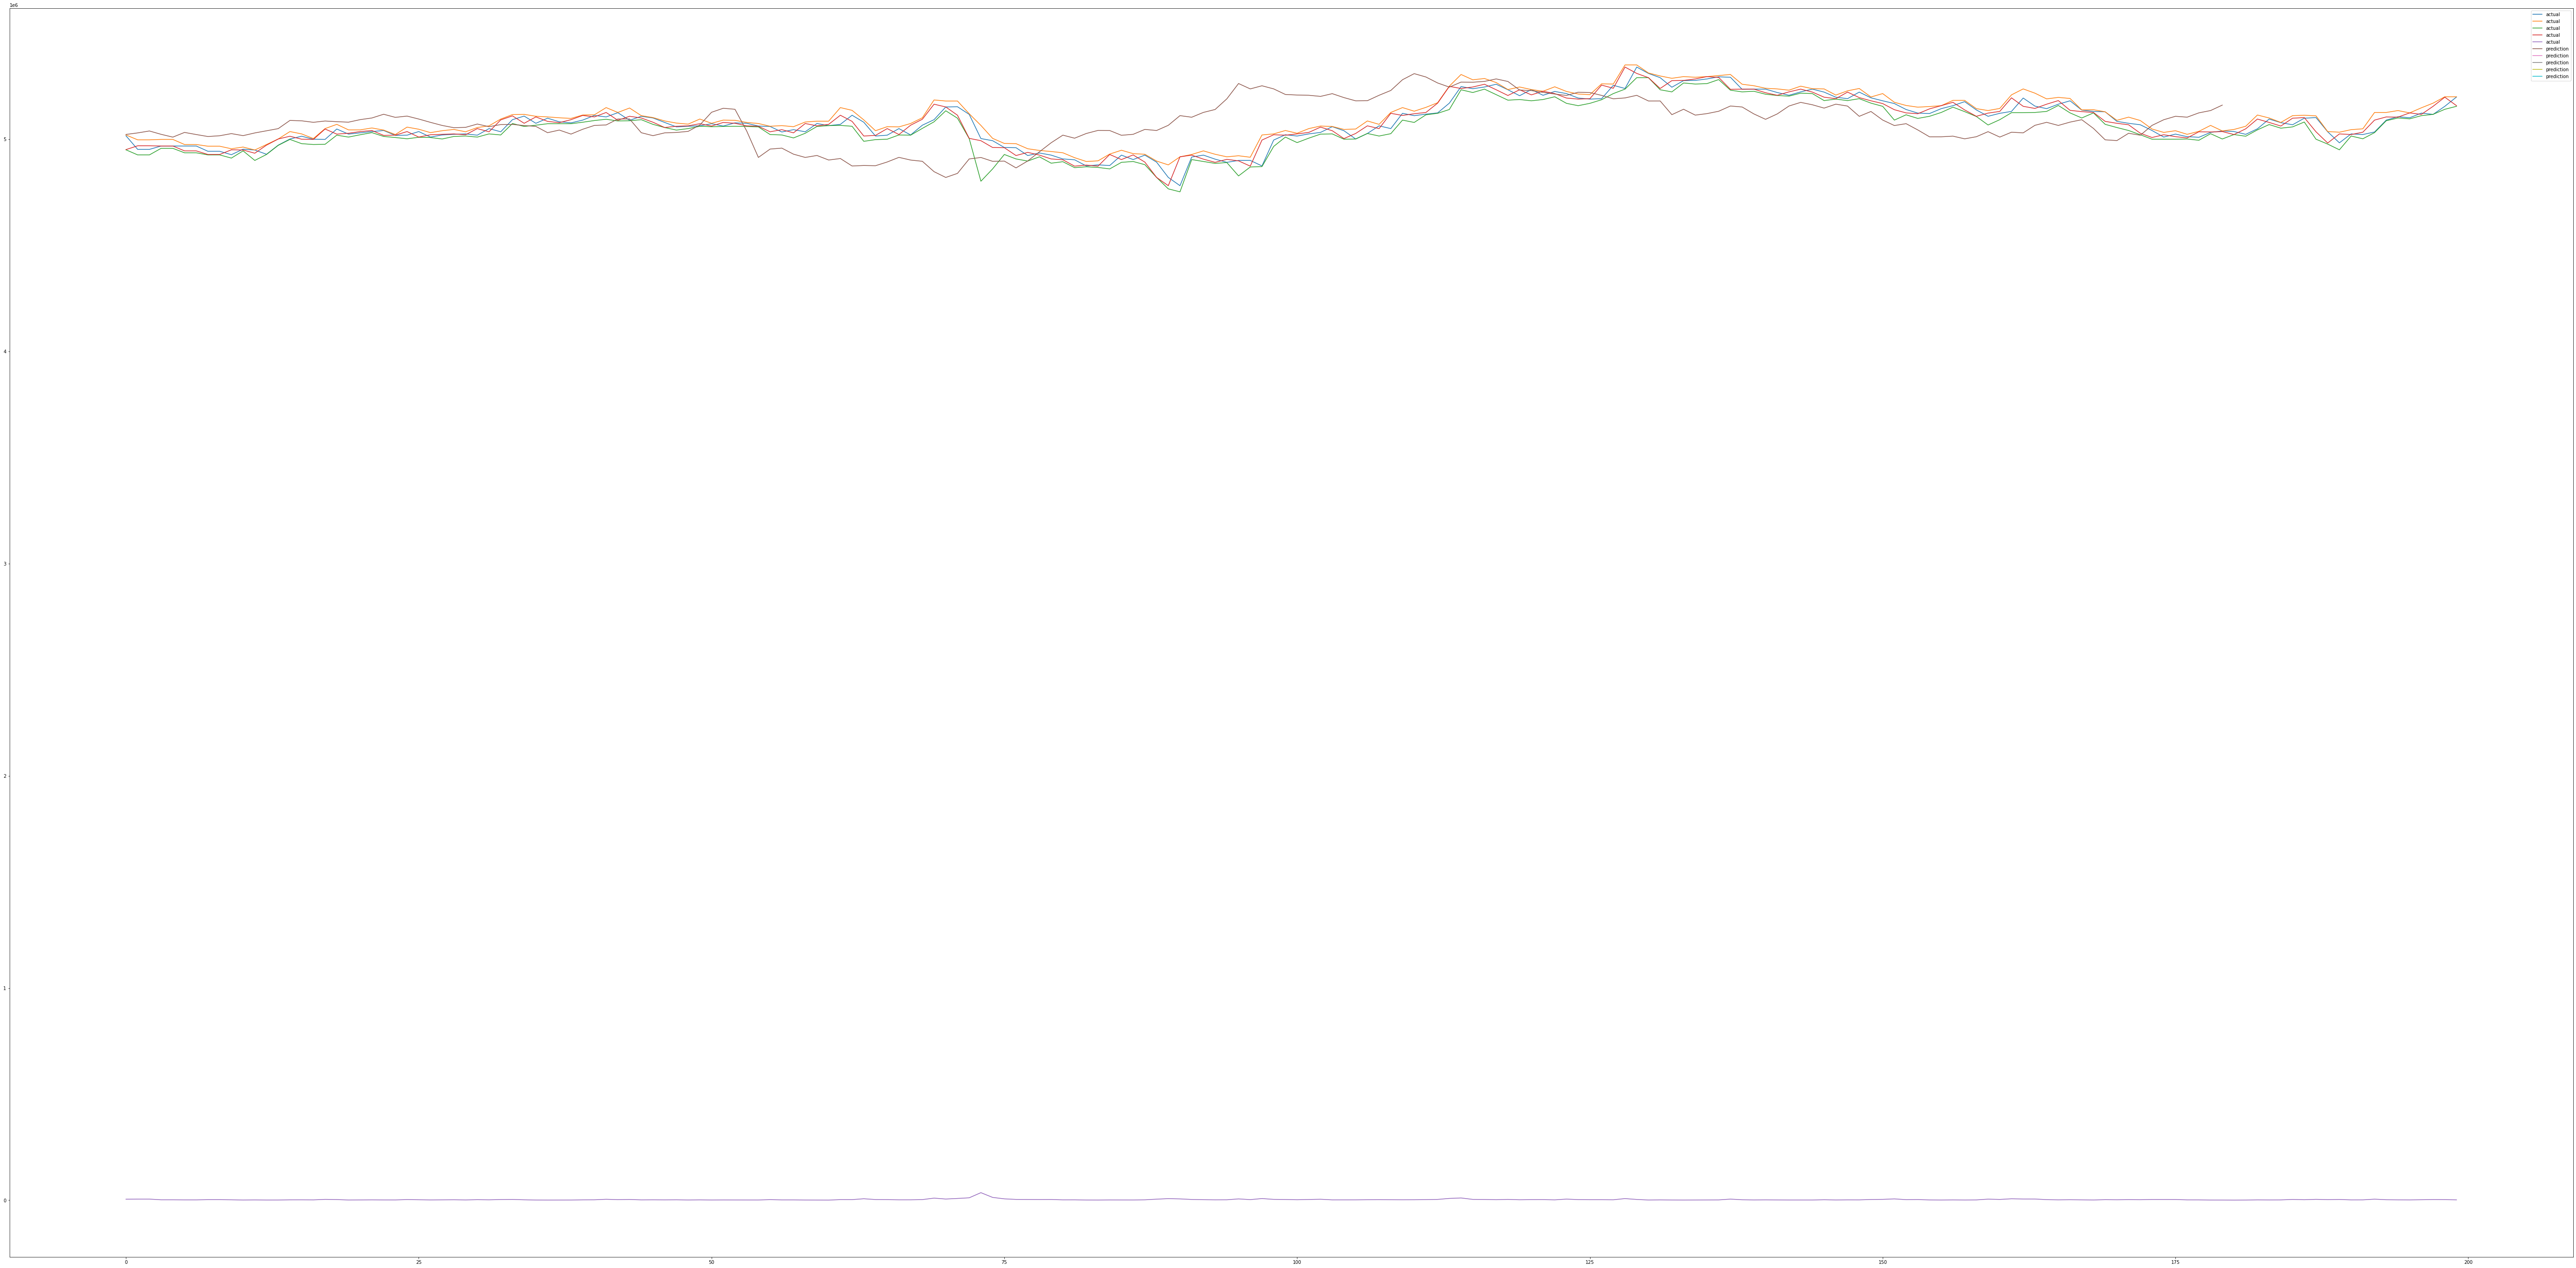

In [ ]:
plt.figure(figsize=(100, 50))
plt.plot(scaler.inverse_transform(test), label = 'actual')
plt.plot(scaler.inverse_transform(pred), label = 'prediction')
plt.legend(loc = 0)
plt.show()

In [ ]:
#매수 시점의 가격
nowValue = pyupbit.get_current_price(coin)
nowValue

In [ ]:
test_feature1 = [75097000.0,	75200000.0, 75200000.0,	74781000.0,	110.657935]
columns = 'open', 'high', 'low', 'close','volume'
test_feature1 = pd.DataFrame(data=test_feature1, columns = columns).reshape(1, 5)
print(test_feature1)

test_feature1.drop('close', axis = 0)
test_feature1.transpose()
test_feature1 = test_feature1[feature_cols]

# test_label1 = test_feature1[label_cols]



test_feature1, test_label1 = make_dataset(test_feature1, _)
# test_feature1 = model.predict(test_feature1)
# my_df = pd.DataFrame(data=test_feature1, index=range(0,4), columns=['A'])

# pred.shape
test_feature1

In [ ]:
scaler = MinMaxScaler()
scale_cols = ['open', 'high', 'low', 'close', 'volume']
test_feature1 = scaler.fit_transform(df[scale_cols])
test_feature1 = pd.DataFrame(test_feature1)
test_feature1.columns = scale_cols

test_feature1

In [ ]:
#종가의 가격을 구함

#현재 시간이 자정 이전
closeDf = forecast[forecast['ds'] == forecast.iloc[-1]['ds'].replace(hour=9)]

#현재 시간이 자정 이후
if len(closeDf) == 0:
  closeDf = forecast[forecast['ds'] == data.iloc[-1]['ds'].replace(hour=9)]

#어쨋든 당일 종가
closeValue = closeDf['yhat'].values[0]
closeValue

In [ ]:
#구체적인 가격
print("현재 시점 가격: ", nowValue)
print("종가의 가격: ", closeValue)

In [ ]:
forecast